# Pilot Analyses -- Psifr Edition

## Setup

In [30]:
#%% Dependencies
import os
new_dr = "/Users/roberttornatore/Desktop/JATOS/study_assets_root/online_experiments"
os.chdir(new_dr)
print(os.getcwd())
from experiments.block_cat.helpers import export_to_psifr_long_table, load_data
from psifr import fr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

/Users/roberttornatore/Desktop/JATOS/study_assets_root/online_experiments


In [31]:
def export_to_psifr_long_table(data: dict[str, np.ndarray]) -> pd.DataFrame:
    """Convert data in EMBAM format to long table psifr format.

    Args:
        data (dict[str, np.ndarray]): Data in EMBAM format. In EMBAM format, data is stored
        in a dictionary where each key corresponds to a different variable. The values are
        2-D numpy arrays where each row corresponds to a trial. Required fields in the EMBAM
        format are: 'subject', 'listLength', 'pres_itemnos', 'recalls'. Additional fields
        such as 'condition', 'pres_itemids', and 'rec_itemids' can identify details about
        the trial or each presented or recalled item.

    Returns:
        pd.DataFrame: A pandas DataFrame whose rows correspond to a single study or recall
        event. The required fields in each row are 'subject', 'list', 'trial_type', 'position',
        and 'item'. Additional fields can be included to describe events, e.g., 'condition'.
    """
    events = {
        "subject": [],
        "list": [],
        "trial_type": [],
        "position": [],
        "item": [],
        "condition": [],
        "target_success": [],
        "listLength": [],
        "trial_category_cue": [],
        "category": [],
    }

    # first all study events
    for trial_index, trial in enumerate(data["pres_itemids"]):
        for study_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("study")
            events["position"].append(study_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["pres_categoryids"][trial_index, study_index]
            )

    # then all recall events
    for trial_index, trial in enumerate(data["rec_itemids"]):
        for recall_index, item in enumerate(trial):
            if item == 0:
                continue
            events["subject"].append(data["subject"][trial_index][0])
            events["list"].append(data["block"][trial_index][0])
            events["trial_type"].append("recall")
            events["position"].append(recall_index + 1)
            events["item"].append(item)
            events["condition"].append(data["condition"][trial_index][0])
            events["target_success"].append(data["target_success"][trial_index][0])
            events["listLength"].append(data["listLength"][trial_index][0])
            events["trial_category_cue"].append(data["category_cues"][trial_index][0])
            events["category"].append(
                data["rec_categoryids"][trial_index, recall_index]
            )

    return pd.DataFrame.from_dict(events)




In [32]:
# %% Load data
embam_data_path = "experiments/block_cat/expt_block_cat.h5"
embam_data = load_data(embam_data_path)
events = export_to_psifr_long_table(embam_data)

# Assign cue types
def determine_cue_type(group):
    cue_cat = group["trial_category_cue"].iloc[0]
    if cue_cat == 0:
        return "control"
    
    pos_cat = dict(zip(group["position"], group["category"]))

    block_positions = [4, 5, 6, 10, 11, 12]
    isolate_positions = [1, 2, 3, 7, 8, 9, 13, 14, 15]

    if any(pos_cat.get(pos) == cue_cat for pos in block_positions):
        return "block"
    elif any(pos_cat.get(pos) == cue_cat for pos in isolate_positions):
        return "isolate"


study_rows = events[events.trial_type == "study"]

cue_types = study_rows.groupby(["subject", "list"]).apply(determine_cue_type).reset_index()
cue_types = cue_types.rename(columns={0: "cue_type"})
events = events.merge(cue_types, on=["subject", "list"], how="left")


#turns out some category cues where not just positions 2, 8, and 14, but any position that is not a block position
#made it so that isolate positions were anything other than block positions
#this adds a cue_type column in the data frame
#want to consider going forward whether it is fine we are cueing any of the isolate positions

events.head()

,subject,list,trial_type,position,item,condition,target_success,listLength,trial_category_cue,category,cue_type
0,0,1,study,1,159,2,True,15,24,9,block
1,0,1,study,2,451,2,True,15,24,26,block
2,0,1,study,3,387,2,True,15,24,23,block
3,0,1,study,4,416,2,True,15,24,24,block
4,0,1,study,5,410,2,True,15,24,24,block


In [33]:
# %% Merge study and recall events
data = fr.merge_free_recall(
    events,
    list_keys=[
        'condition',
        'target_success',
        'listLength',
        'trial_category_cue',
        'category',
        'cue_type'  
    ]
)

data

,subject,list,item,input,output,study,recall,repeat,intrusion,condition,target_success,listLength,trial_category_cue,category,cue_type,prior_list,prior_input
0,0,1,159,1,NaN,True,False,0,False,2,True,15,24,9,block,NaN,NaN
1,0,1,451,2,NaN,True,False,0,False,2,True,15,24,26,block,NaN,NaN
2,0,1,387,3,NaN,True,False,0,False,2,True,15,24,23,block,NaN,NaN
3,0,1,416,4,NaN,True,False,0,False,2,True,15,24,24,block,NaN,NaN
4,0,1,410,5,NaN,True,False,0,False,2,True,15,24,24,block,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,7,15,542,11,NaN,True,False,0,False,2,True,15,31,31,block,NaN,NaN
1844,7,15,540,12,1.0,True,True,0,False,2,True,15,31,31,block,NaN,NaN
1845,7,15,121,13,3.0,True,True,0,False,2,True,15,31,7,block,NaN,NaN
1846,7,15,327,14,NaN,True,False,0,False,2,True,15,31,19,block,NaN,NaN


## Demo Analyses

Pretty colors.

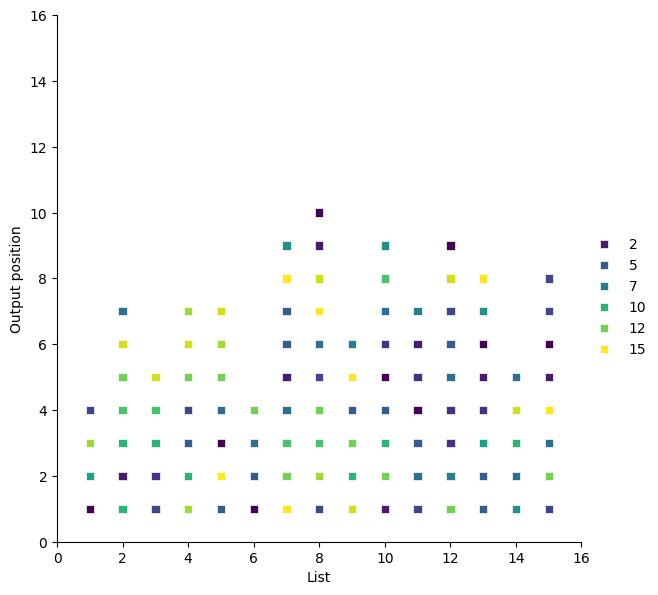

In [34]:
# %% Raster Plot
subj = fr.filter_data(data, 1)
g = fr.plot_raster(subj).add_legend()

Successfully reduced primacy effect in PFR? Yeah. For now.

,subject,output,input,prob,actual,possible,condition
0,0,1,1,0.0,0,6,control
1,0,1,2,0.0,0,6,control
2,0,1,3,0.0,0,6,control
3,0,1,4,0.0,0,6,control
4,0,1,5,0.0,0,6,control
...,...,...,...,...,...,...,...
1795,7,15,11,NaN,0,0,isolate
1796,7,15,12,NaN,0,0,isolate
1797,7,15,13,NaN,0,0,isolate
1798,7,15,14,NaN,0,0,isolate


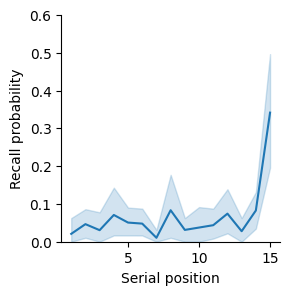

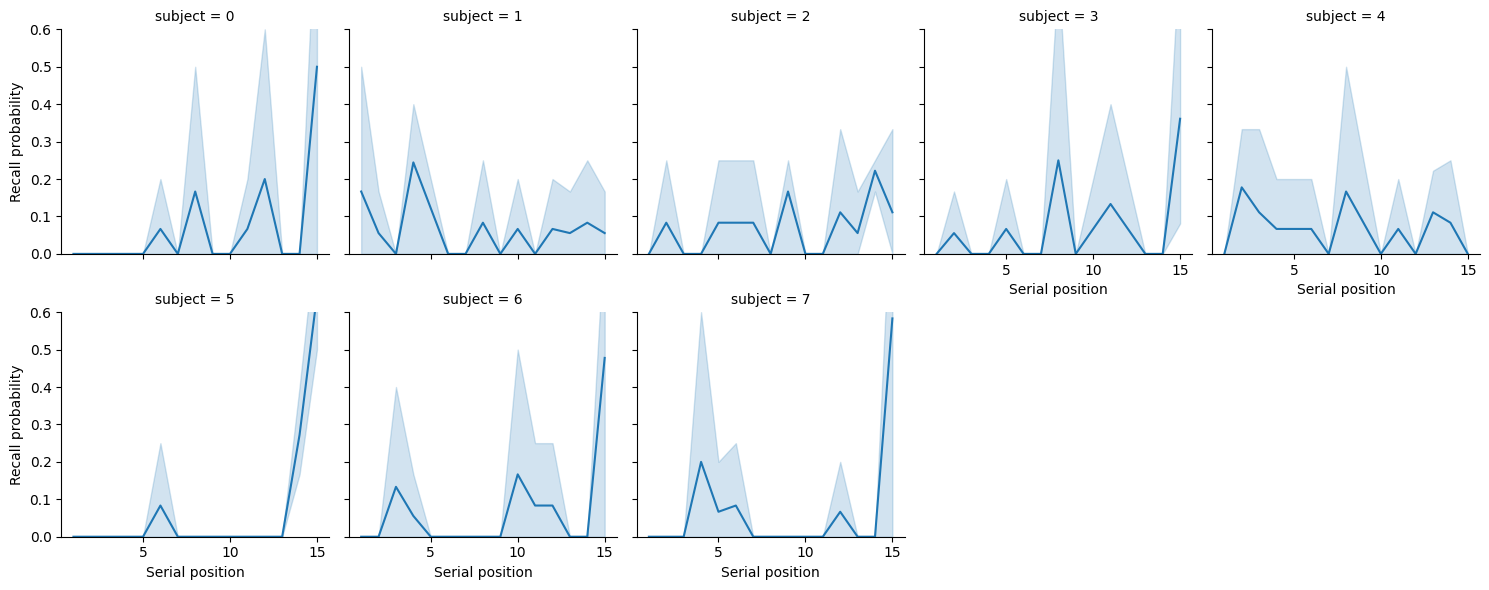

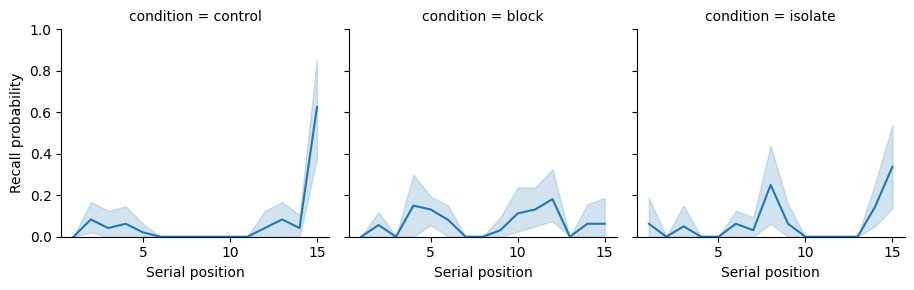

In [35]:
# %% PFR

pnr_control = fr.pnr(data.query('cue_type == "control"'))
pnr_block = fr.pnr(data.query('cue_type == "block"'))
pnr_isolate = fr.pnr(data.query('cue_type == "isolate"'))

pnr = pd.concat([
    pnr_control.assign(condition='control'),
    pnr_block.assign(condition='block'),
    pnr_isolate.assign(condition='isolate')
])

# Limit to first recall
pfr = pnr.query('output <= 1')

# Plotting
g = fr.plot_spc(pfr)
plt.ylim([0, .6])
g = fr.plot_spc(pfr, col='subject', col_wrap=5)
plt.ylim([0, .6])
g = fr.plot_spc(pfr, col='condition', col_wrap=5)

pnr


Look at what's recalled after the category-cued item.

,subject,output,input,prob,actual,possible,condition
15,0,2,1,0.00,0,6,control
16,0,2,2,0.00,0,6,control
17,0,2,3,0.00,0,6,control
18,0,2,4,0.00,0,6,control
19,0,2,5,0.00,0,6,control
...,...,...,...,...,...,...,...
1600,7,2,11,0.00,0,4,isolate
1601,7,2,12,0.25,1,4,isolate
1602,7,2,13,0.00,0,4,isolate
1603,7,2,14,0.75,3,4,isolate


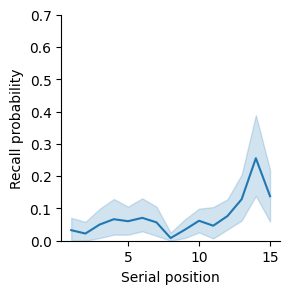

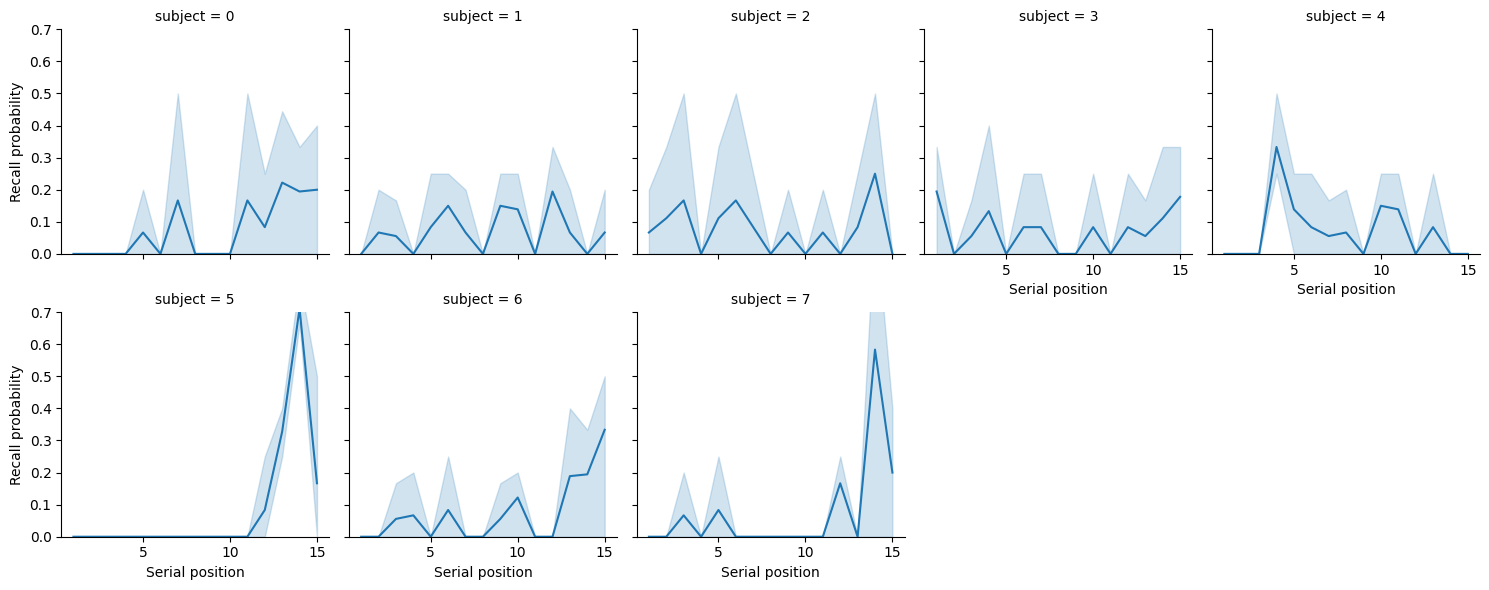

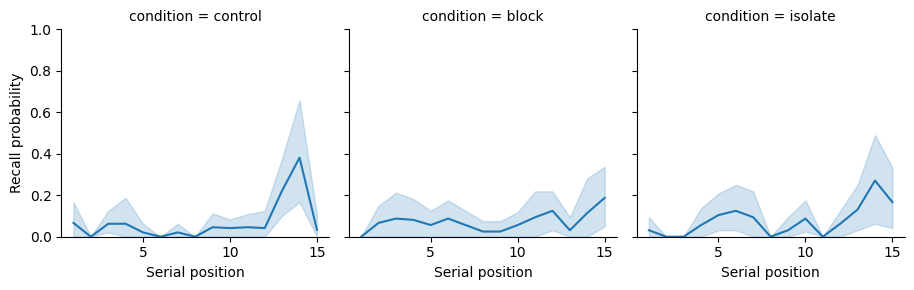

In [36]:
# %% P2R

pnr_control = fr.pnr(data.query('cue_type == "control"'))
pnr_block = fr.pnr(data.query('cue_type == "block"'))
pnr_isolate = fr.pnr(data.query('cue_type == "isolate"'))

pnr = pd.concat([
    pnr_control.assign(condition='control'),
    pnr_block.assign(condition='block'),
    pnr_isolate.assign(condition='isolate')
])

# Limit to first recall
p2r = pnr.query('output == 2')

# Plotting
g = fr.plot_spc(p2r)
plt.ylim([0, .7])
g = fr.plot_spc(p2r, col='subject', col_wrap=5)
plt.ylim([0, .7])
g = fr.plot_spc(p2r, col='condition', col_wrap=5)

p2r

,subject,output,input,prob,actual,possible,condition
15,0,2,1,0.0,0,6,control
16,0,2,2,0.0,0,6,control
17,0,2,3,0.0,0,6,control
18,0,2,4,0.0,0,6,control
19,0,2,5,0.0,0,6,control
...,...,...,...,...,...,...,...
925,7,2,11,0.0,0,2,isolate_failure
926,7,2,12,0.5,1,2,isolate_failure
927,7,2,13,0.0,0,2,isolate_failure
928,7,2,14,0.5,1,2,isolate_failure


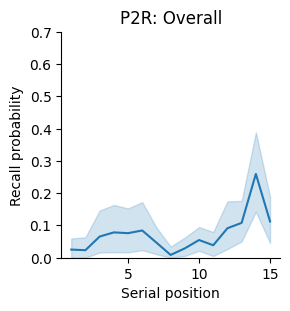

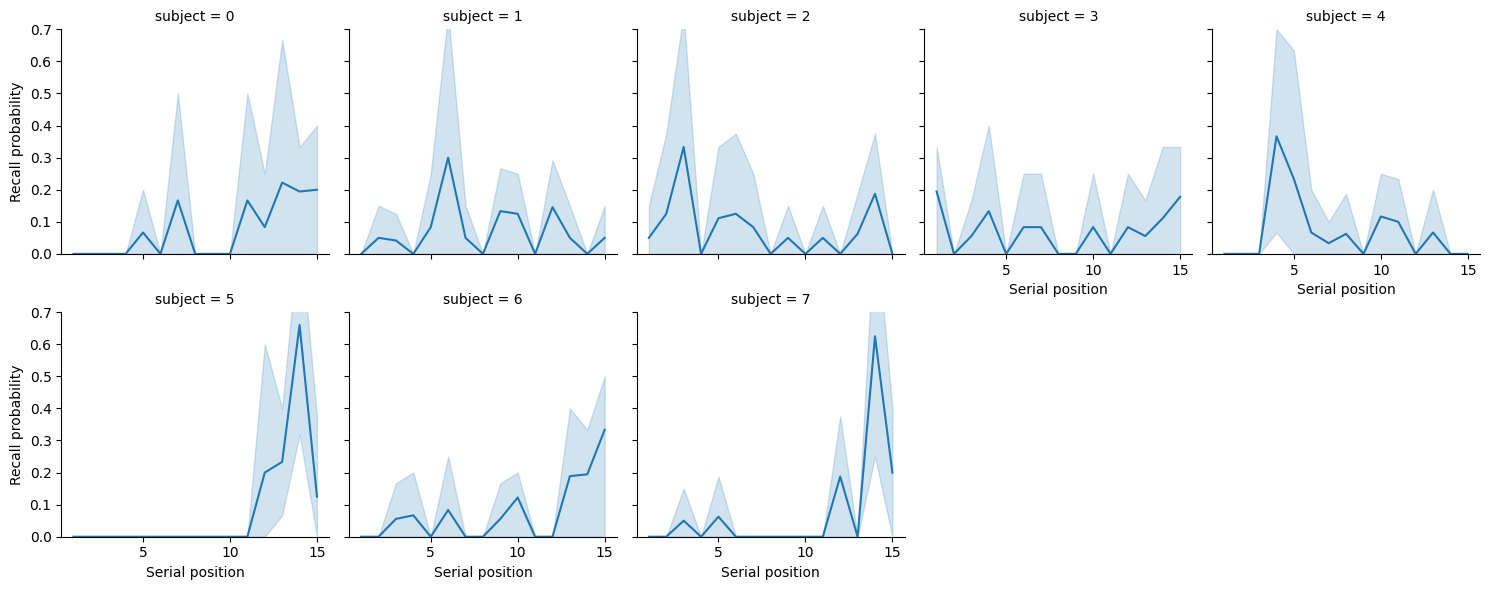

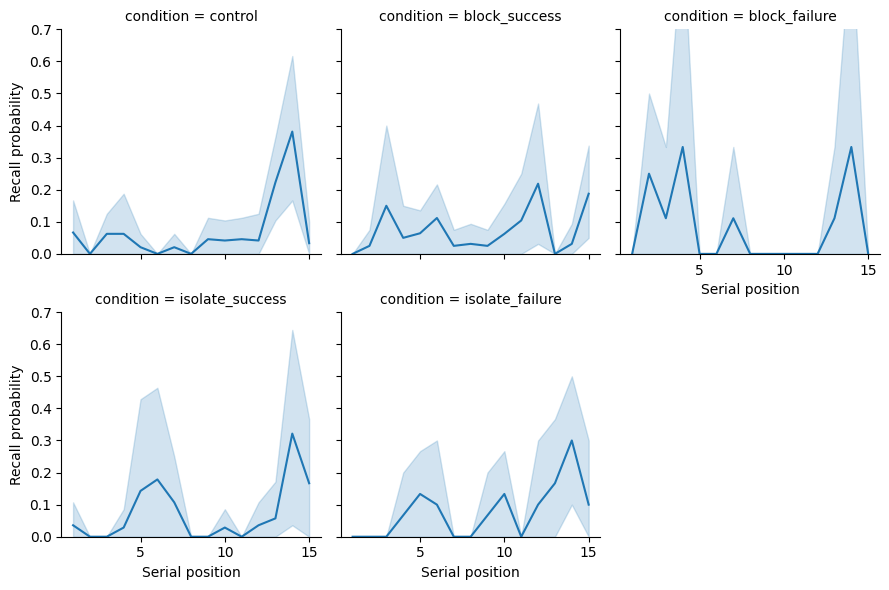

In [37]:
# %% P2R

# Generate PNR data per condition
pnr_control = fr.pnr(data.query('cue_type == "control"'))

pnr_block_success = fr.pnr(data.query('cue_type == "block" and target_success == 1'))
pnr_block_failure = fr.pnr(data.query('cue_type == "block" and target_success == 0'))

pnr_isolate_success = fr.pnr(data.query('cue_type == "isolate" and target_success == 1'))
pnr_isolate_failure = fr.pnr(data.query('cue_type == "isolate" and target_success == 0'))

# Combine all
pnr = pd.concat([
    pnr_control.assign(condition='control'),
    pnr_block_success.assign(condition='block_success'),
    pnr_block_failure.assign(condition='block_failure'),
    pnr_isolate_success.assign(condition='isolate_success'),
    pnr_isolate_failure.assign(condition='isolate_failure'),
])

# Limit to second recall only (output == 2)
p2r = pnr.query('output == 2')

# Plotting
import matplotlib.pyplot as plt

g = fr.plot_spc(p2r)
plt.ylim([0, 0.7])
plt.title("P2R: Overall")

g = fr.plot_spc(p2r, col='subject', col_wrap=5)
plt.ylim([0, 0.7])

g = fr.plot_spc(p2r, col='condition', col_wrap=3)
plt.ylim([0, 0.7])

p2r


Is lag-contiguity disrupted by our category cueing?

,subject,lag,prob,actual,possible,condition
0,0,-14,0.000000,0,6,control
1,0,-13,0.000000,0,8,control
2,0,-12,0.066667,1,15,control
3,0,-11,0.000000,0,20,control
4,0,-10,0.000000,0,26,control
...,...,...,...,...,...,...
140,7,10,0.000000,0,1,isolate_failure
141,7,11,0.000000,0,1,isolate_failure
142,7,12,0.000000,0,2,isolate_failure
143,7,13,0.000000,0,2,isolate_failure


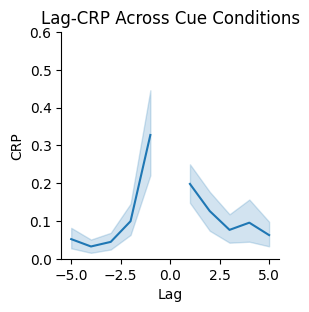

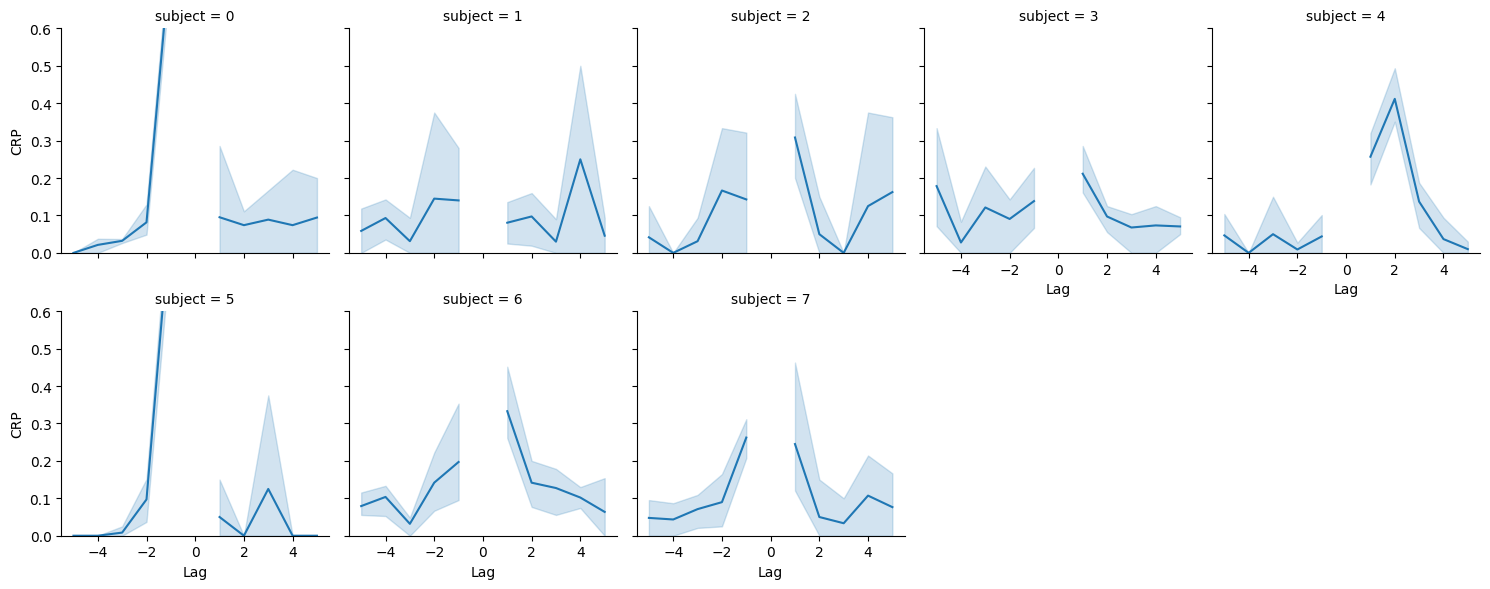

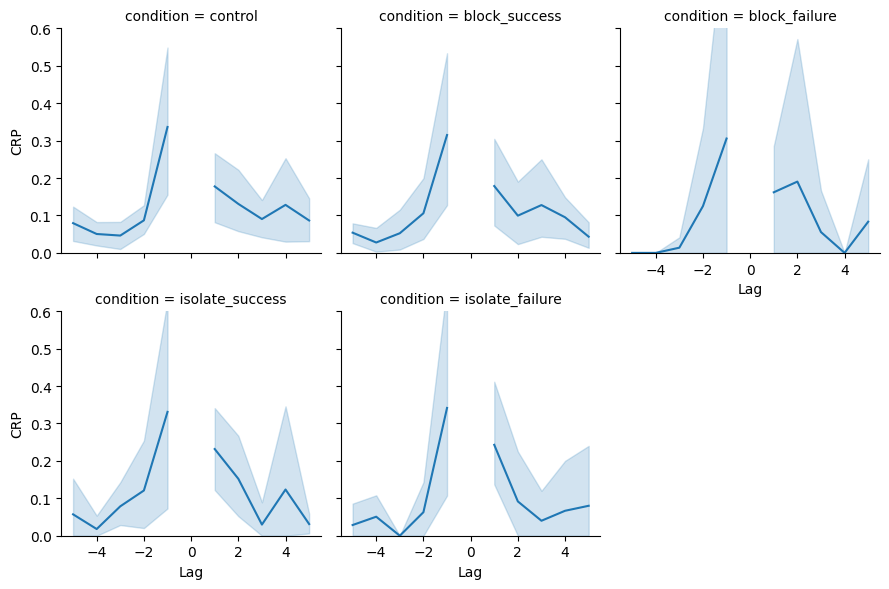

In [38]:
# %% Lag-CRP 

# Control
crp_control = fr.lag_crp(data.query('cue_type == "control"'))

# Block trials
crp_block_success = fr.lag_crp(data.query('cue_type == "block" and target_success == 1'))
crp_block_failure = fr.lag_crp(data.query('cue_type == "block" and target_success == 0'))

# Isolate trials
crp_isolate_success = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 1'))
crp_isolate_failure = fr.lag_crp(data.query('cue_type == "isolate" and target_success == 0'))

# Combine all
lag_crp = pd.concat([
    crp_control.assign(condition='control'),
    crp_block_success.assign(condition='block_success'),
    crp_block_failure.assign(condition='block_failure'),
    crp_isolate_success.assign(condition='isolate_success'),
    crp_isolate_failure.assign(condition='isolate_failure'),
])

# Plot
import matplotlib.pyplot as plt

g = fr.plot_lag_crp(lag_crp)
plt.ylim([0, .6])
plt.title("Lag-CRP Across Cue Conditions")

# Subject-level breakdown
g = fr.plot_lag_crp(lag_crp, col='subject', col_wrap=5)
plt.ylim([0, .6])

# Condition-level breakdown
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=3)
plt.ylim([0, .6])

lag_crp



,subject,lag,prob,actual,possible,condition
0,1,-14,0.333333,1,3,control
1,1,-13,0.000000,0,4,control
2,1,-12,0.166667,1,6,control
3,1,-11,0.000000,0,9,control
4,1,-10,0.000000,0,11,control
...,...,...,...,...,...,...
111,7,10,0.000000,0,1,isolate_failure
112,7,11,0.000000,0,1,isolate_failure
113,7,12,0.000000,0,2,isolate_failure
114,7,13,0.000000,0,2,isolate_failure


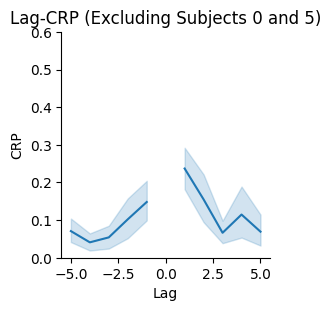

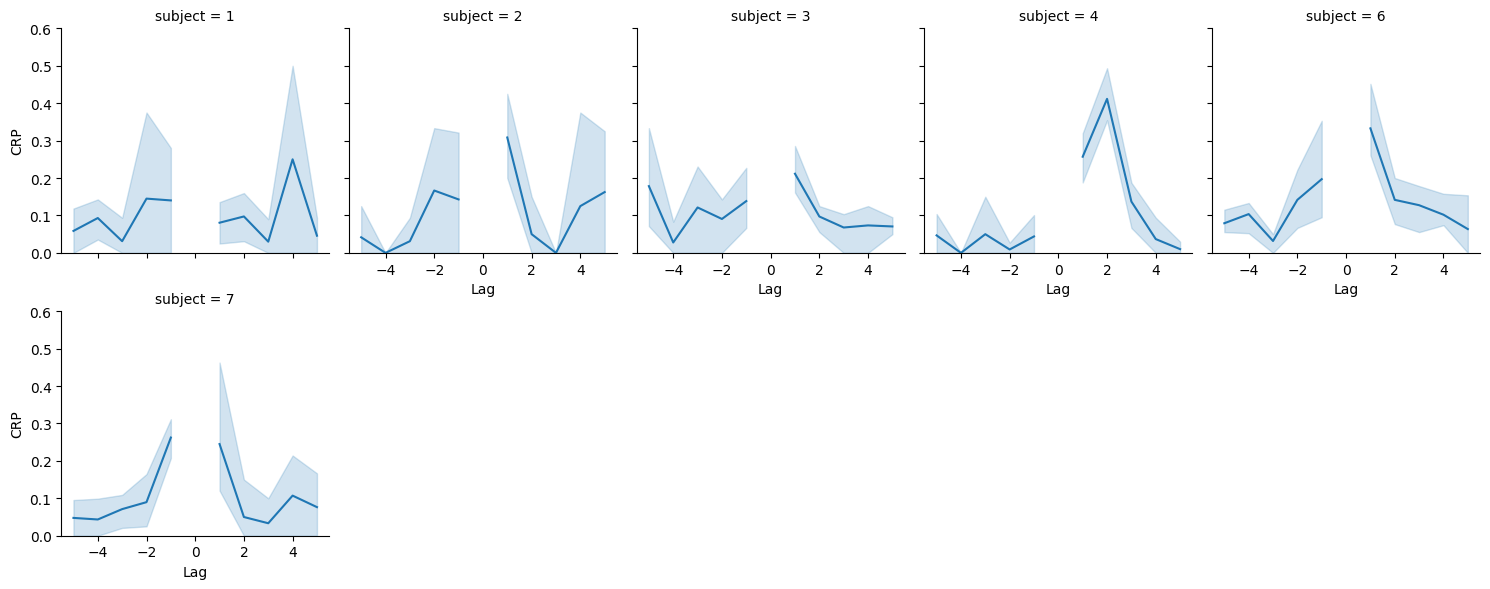

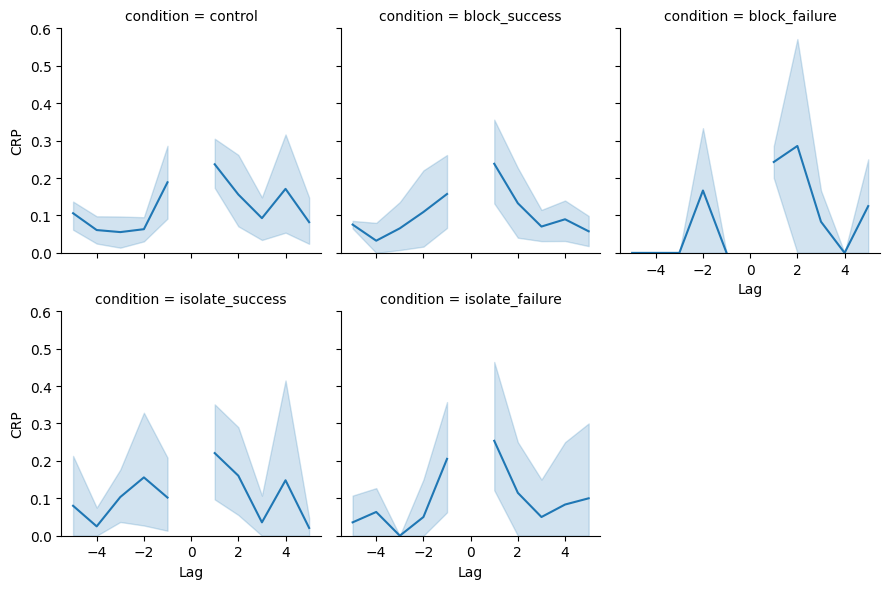

In [39]:
# %% Lag-CRP excluding subjects 0 and 5

exclude = 'subject != 0 and subject != 5'

# Control 
crp_control = fr.lag_crp(data.query(f'cue_type == "control" and {exclude}'))

# Block cue: success & failure
crp_block_success = fr.lag_crp(data.query(f'cue_type == "block" and target_success == 1 and {exclude}'))
crp_block_failure = fr.lag_crp(data.query(f'cue_type == "block" and target_success == 0 and {exclude}'))

# Isolate cue: success & failure
crp_isolate_success = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 1 and {exclude}'))
crp_isolate_failure = fr.lag_crp(data.query(f'cue_type == "isolate" and target_success == 0 and {exclude}'))

# Combine
lag_crp = pd.concat([
    crp_control.assign(condition='control'),
    crp_block_success.assign(condition='block_success'),
    crp_block_failure.assign(condition='block_failure'),
    crp_isolate_success.assign(condition='isolate_success'),
    crp_isolate_failure.assign(condition='isolate_failure'),
])

# Plot
import matplotlib.pyplot as plt

g = fr.plot_lag_crp(lag_crp)
plt.ylim([0, .6])
plt.title("Lag-CRP (Excluding Subjects 0 and 5)")

g = fr.plot_lag_crp(lag_crp, col='subject', col_wrap=5)
plt.ylim([0, .6])

g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=3)
plt.ylim([0, .6])

lag_crp



In [40]:
# %% Lag-Rank Analysis 

ranks_control = fr.lag_rank(data.query('cue_type == "control"'))
ranks_block = fr.lag_rank(data.query('cue_type == "block"'))
ranks_isolate = fr.lag_rank(data.query('cue_type == "isolate"'))

ranks = pd.concat([
    ranks_control.assign(condition='control'),
    ranks_block.assign(condition='block'),
    ranks_isolate.assign(condition='isolate')
])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("block")
print(ranks_block.agg(['mean', 'sem'])['rank'])
print("isolate")
print(ranks_isolate.agg(['mean', 'sem'])['rank'])

ranks


control
mean    0.715887
sem     0.053766
Name: rank, dtype: float64
block
mean    0.705655
sem     0.056328
Name: rank, dtype: float64
isolate
mean    0.720383
sem     0.055788
Name: rank, dtype: float64


,subject,rank,condition
0,0,0.889097,control
1,1,0.596515,control
2,2,0.714489,control
3,3,0.499536,control
4,4,0.749167,control
5,5,0.953858,control
6,6,0.722733,control
7,7,0.601696,control
0,0,0.938350,block
1,1,0.583126,block


In [41]:
# %% Lag-Rank Analysis

block_success = 'cue_type == "block" and target_success == 1'
block_failure = 'cue_type == "block" and target_success == 0'
isolate_success = 'cue_type == "isolate" and target_success == 1'
isolate_failure = 'cue_type == "isolate" and target_success == 0'

ranks_control = fr.lag_rank(data.query('cue_type == "control"'))
ranks_block_success = fr.lag_rank(data.query(block_success))
ranks_block_failure = fr.lag_rank(data.query(block_failure))
ranks_isolate_success = fr.lag_rank(data.query(isolate_success))
ranks_isolate_failure = fr.lag_rank(data.query(isolate_failure))

ranks = pd.concat([
    ranks_control.assign(condition='control'),
    ranks_block_success.assign(condition='block_success'),
    ranks_block_failure.assign(condition='block_failure'),
    ranks_isolate_success.assign(condition='isolate_success'),
    ranks_isolate_failure.assign(condition='isolate_failure'),
])

for name, df in {
    "control": ranks_control,
    "block_success": ranks_block_success,
    "block_failure": ranks_block_failure,
    "isolate_success": ranks_isolate_success,
    "isolate_failure": ranks_isolate_failure
}.items():
    print(f"{name}")
    print(df.agg(['mean', 'sem'])['rank'])

ranks


control
mean    0.715887
sem     0.053766
Name: rank, dtype: float64
block_success
mean    0.702693
sem     0.049270
Name: rank, dtype: float64
block_failure
mean    0.775316
sem     0.112639
Name: rank, dtype: float64
isolate_success
mean    0.721623
sem     0.063639
Name: rank, dtype: float64
isolate_failure
mean    0.715020
sem     0.080711
Name: rank, dtype: float64


,subject,rank,condition
0,0,0.889097,control
1,1,0.596515,control
2,2,0.714489,control
3,3,0.499536,control
4,4,0.749167,control
5,5,0.953858,control
6,6,0.722733,control
7,7,0.601696,control
0,0,0.938350,block_success
1,1,0.583126,block_success


In [42]:
# %% Lag-Rank Analysis, excluding subjects 0 & 5

excluded_subjects =  'subject != 0 and subject != 5'

ranks_control = fr.lag_rank(data.query(f'cue_type == "control" and {excluded_subjects}'))
ranks_block = fr.lag_rank(data.query(f'cue_type == "block" and {excluded_subjects}'))
ranks_isolate = fr.lag_rank(data.query(f'cue_type == "isolate" and {excluded_subjects}'))

ranks = pd.concat([
    ranks_control.assign(condition='control'),
    ranks_block.assign(condition='block'),
    ranks_isolate.assign(condition='isolate')
])

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("block")
print(ranks_block.agg(['mean', 'sem'])['rank'])
print("isolate")
print(ranks_isolate.agg(['mean', 'sem'])['rank'])

ranks

control
mean    0.647356
sem     0.039612
Name: rank, dtype: float64
block
mean    0.626258
sem     0.029621
Name: rank, dtype: float64
isolate
mean    0.643158
sem     0.030883
Name: rank, dtype: float64


,subject,rank,condition
0,1,0.596515,control
1,2,0.714489,control
2,3,0.499536,control
3,4,0.749167,control
4,6,0.722733,control
5,7,0.601696,control
0,1,0.583126,block
1,2,0.635999,block
2,3,0.569010,block
3,4,0.741102,block


## How Often Do Subjects Recall the Category Target?

In [43]:
# %% Focus on targetting trials, then aggregating target_success by subject
success_rates = data.query('condition > 0').pivot_table(
    index='subject', values='target_success', aggfunc='mean')

# mean and sem over subjects
print(success_rates.agg(['mean', 'sem'])['target_success'])
success_rates

mean    0.669359
sem     0.124208
Name: target_success, dtype: float64


,target_success
subject,
0,1.000000
1,0.680851
2,0.107914
3,1.000000
4,0.555556
5,0.227941
6,1.000000
7,0.782609


## Focusing on Transitions From Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-14,0.0,0,4,control
1,0,-13,0.0,0,5,control
2,0,-12,0.0,0,5,control
3,0,-11,0.0,0,4,control
4,0,-10,0.0,0,1,control
...,...,...,...,...,...,...
227,7,10,NaN,0,0,isolate
228,7,11,NaN,0,0,isolate
229,7,12,NaN,0,0,isolate
230,7,13,NaN,0,0,isolate


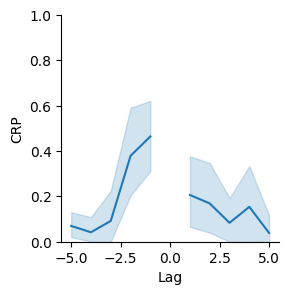

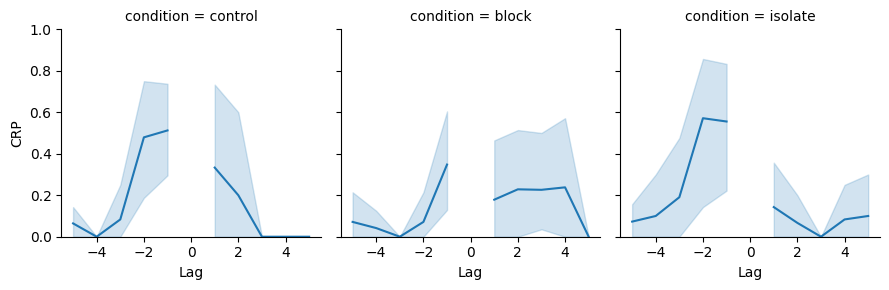

In [44]:
# %% First Transition Lag-CRP 

item_filter = 'output < 3 or not recall'

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block = fr.lag_crp(data.query('cue_type == "block"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition='control'),
    crp_block.assign(condition='block'),
    crp_isolate.assign(condition='isolate')
])

# Plot
g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=3)
lag_crp


,subject,lag,prob,actual,possible,condition
0,1,-14,0.0,0,1,control
1,1,-13,NaN,0,0,control
2,1,-12,0.0,0,2,control
3,1,-11,0.0,0,2,control
4,1,-10,0.0,0,1,control
...,...,...,...,...,...,...
111,7,10,NaN,0,0,isolate_failure
112,7,11,NaN,0,0,isolate_failure
113,7,12,NaN,0,0,isolate_failure
114,7,13,NaN,0,0,isolate_failure


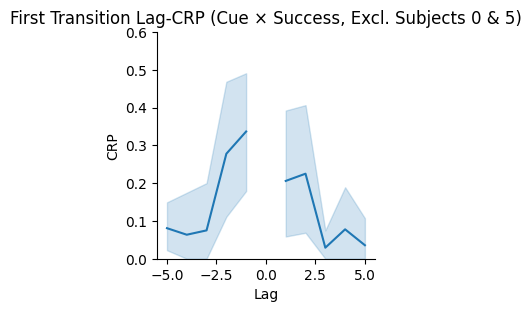

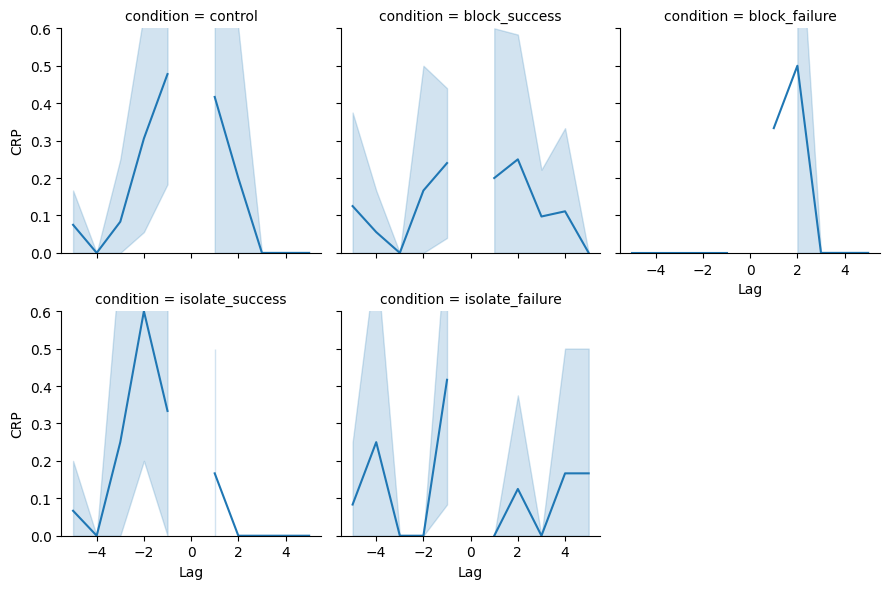

In [45]:
# %% First Transition Lag-CRP by success/failure, excluding subjects 0 & 5

exclude_subjects = 'subject != 0 and subject != 5'
item_filter = 'output < 3 or not recall'

# Control (no success/failure distinction)
crp_control = fr.lag_crp(
    data.query(f'cue_type == "control" and {exclude_subjects}'),
    item_query=item_filter
)

# Block cue
crp_block_success = fr.lag_crp(
    data.query(f'cue_type == "block" and target_success == 1 and {exclude_subjects}'),
    item_query=item_filter
)
crp_block_failure = fr.lag_crp(
    data.query(f'cue_type == "block" and target_success == 0 and {exclude_subjects}'),
    item_query=item_filter
)

# Isolate cue
crp_isolate_success = fr.lag_crp(
    data.query(f'cue_type == "isolate" and target_success == 1 and {exclude_subjects}'),
    item_query=item_filter
)
crp_isolate_failure = fr.lag_crp(
    data.query(f'cue_type == "isolate" and target_success == 0 and {exclude_subjects}'),
    item_query=item_filter
)

# Combine
lag_crp_ex = pd.concat([
    crp_control.assign(condition='control'),
    crp_block_success.assign(condition='block_success'),
    crp_block_failure.assign(condition='block_failure'),
    crp_isolate_success.assign(condition='isolate_success'),
    crp_isolate_failure.assign(condition='isolate_failure'),
])

# Plot
import matplotlib.pyplot as plt

g = fr.plot_lag_crp(lag_crp_ex)
plt.ylim([0, 0.6])
plt.title("First Transition Lag-CRP (Cue × Success, Excl. Subjects 0 & 5)")

g = fr.plot_lag_crp(lag_crp_ex, col='condition', col_wrap=3)
plt.ylim([0, 0.6])

lag_crp_ex



,subject,lag,prob,actual,possible,condition
0,0,-14,NaN,0,0,control
1,0,-13,NaN,0,0,control
2,0,-12,0.0,0,5,control
3,0,-11,0.0,0,4,control
4,0,-10,0.0,0,1,control
...,...,...,...,...,...,...
227,7,10,NaN,0,0,isolate
228,7,11,NaN,0,0,isolate
229,7,12,NaN,0,0,isolate
230,7,13,NaN,0,0,isolate


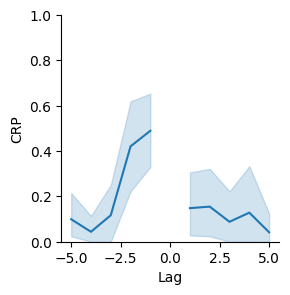

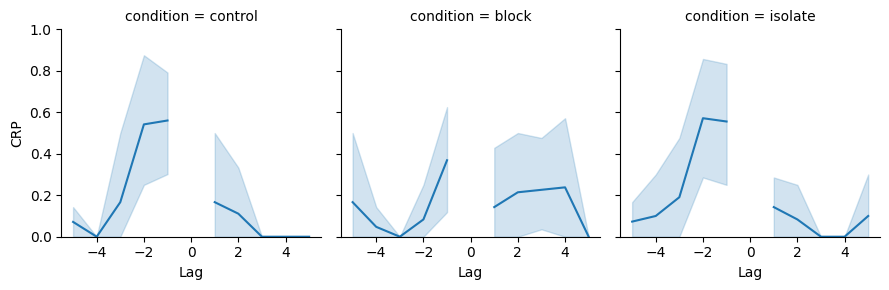

In [46]:
# %% Lag-CRP (exclude transitions to first input items)

item_filter = '(output < 3 or not recall) and input > 2'

crp_control = fr.lag_crp(data.query('cue_type == "control"'), item_query=item_filter)
crp_block = fr.lag_crp(data.query('cue_type == "block"'), item_query=item_filter)
crp_isolate = fr.lag_crp(data.query('cue_type == "isolate"'), item_query=item_filter)

lag_crp = pd.concat([
    crp_control.assign(condition='control'),
    crp_block.assign(condition='block'),
    crp_isolate.assign(condition='isolate'),
])

# Plot
g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=3)
lag_crp


In [47]:
# %% First Transition Lag-Rank Excluding Subjects 0 & 5

item_filter = 'output < 3 or not recall'
exclude_subjects = 'subject != 0 and subject != 5'

ranks_control = fr.lag_rank(data.query(f'cue_type == "control" and {exclude_subjects}'), item_query=item_filter)
ranks_block = fr.lag_rank(data.query(f'cue_type == "block" and {exclude_subjects}'), item_query=item_filter)
ranks_isolate = fr.lag_rank(data.query(f'cue_type == "isolate" and {exclude_subjects}'), item_query=item_filter)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("block")
print(ranks_block.agg(['mean', 'sem'])['rank'])
print("isolate")
print(ranks_isolate.agg(['mean', 'sem'])['rank'])

ranks_block  


control
mean    0.738083
sem     0.068375
Name: rank, dtype: float64
block
mean    0.553576
sem     0.069698
Name: rank, dtype: float64
isolate
mean    0.740656
sem     0.067882
Name: rank, dtype: float64


,subject,rank
0,1,0.369048
1,2,0.602127
2,3,0.370370
3,4,0.826894
4,6,0.578571
5,7,0.574444


In [48]:
# %% First Transition Lag-Rank

item_filter = 'output < 3 or not recall'

ranks_control = fr.lag_rank(data.query(f'cue_type == "control"'), item_query=item_filter)
ranks_block = fr.lag_rank(data.query(f'cue_type == "block"'), item_query=item_filter)
ranks_isolate = fr.lag_rank(data.query(f'cue_type == "isolate"'), item_query=item_filter)

print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("block")
print(ranks_block.agg(['mean', 'sem'])['rank'])
print("isolate")
print(ranks_isolate.agg(['mean', 'sem'])['rank'])

ranks_block
ranks_control
ranks_isolate 


control
mean    0.780038
sem     0.058056
Name: rank, dtype: float64
block
mean    0.612950
sem     0.065339
Name: rank, dtype: float64
isolate
mean    0.786296
sem     0.058796
Name: rank, dtype: float64


,subject,rank
0,0,0.975000
1,1,0.694444
2,2,0.526515
3,3,1.000000
4,4,0.645833
5,5,0.871429
6,6,0.720000
7,7,0.857143


## Modification: Ignore Transitions to First Item from Category Targets

,subject,lag,prob,actual,possible,condition
0,0,-14,NaN,0,0,control
1,0,-13,0.0,0,5,control
2,0,-12,0.0,0,5,control
3,0,-11,0.0,0,4,control
4,0,-10,0.0,0,1,control
...,...,...,...,...,...,...
140,7,10,NaN,0,0,failure
141,7,11,NaN,0,0,failure
142,7,12,NaN,0,0,failure
143,7,13,NaN,0,0,failure


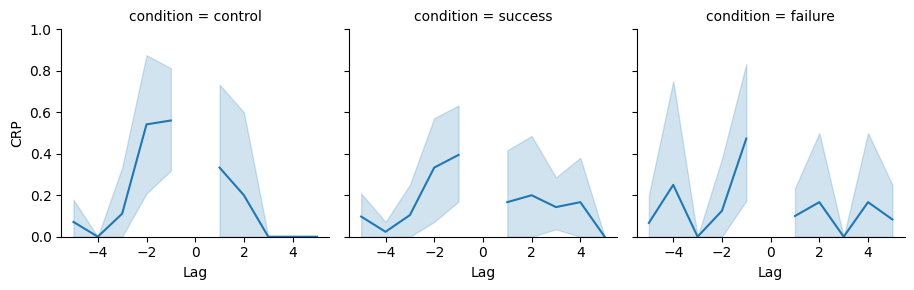

In [49]:
crp_control = fr.lag_crp(
    data.query('condition == 0'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_success = fr.lag_crp(
    data.query('condition == 2'), 
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
crp_attempt = fr.lag_crp(
    data.query('condition == 1'),
    item_query='output < 3 or not recall',
    test_key='input', test=lambda x, y: y > 1
)
lag_crp = pd.concat([crp_control.assign(condition='control'), crp_success.assign(condition='success'), crp_attempt.assign(condition='failure')])

# g = fr.plot_lag_crp(lag_crp)
g = fr.plot_lag_crp(lag_crp, col='condition', col_wrap=5)
lag_crp

In [50]:
# %% Lag-Rank (first transitions, excluding input 1, grouped by cue_type)

ranks_control = fr.lag_rank(
    data.query('cue_type == "control"'), 
    item_query='output < 3 or not recall',
    test_key='input', 
    test=lambda x, y: y > 1
)

ranks_block = fr.lag_rank(
    data.query('cue_type == "block"'), 
    item_query='output < 3 or not recall',
    test_key='input', 
    test=lambda x, y: y > 1
)

ranks_isolate = fr.lag_rank(
    data.query('cue_type == "isolate"'), 
    item_query='output < 3 or not recall',
    test_key='input', 
    test=lambda x, y: y > 1
)

ranks = pd.concat([
    ranks_control.assign(condition='control'),
    ranks_block.assign(condition='block'),
    ranks_isolate.assign(condition='isolate'),
])

# Print summary stats
print("control")
print(ranks_control.agg(['mean', 'sem'])['rank'])
print("block")
print(ranks_block.agg(['mean', 'sem'])['rank'])
print("isolate")
print(ranks_isolate.agg(['mean', 'sem'])['rank'])

ranks_block  


control
mean    0.836271
sem     0.059812
Name: rank, dtype: float64
block
mean    0.601596
sem     0.067160
Name: rank, dtype: float64
isolate
mean    0.773723
sem     0.063741
Name: rank, dtype: float64


,subject,rank
0,0,0.812500
1,1,0.341270
2,2,0.566667
3,3,0.370370
4,4,0.865714
5,5,0.718750
6,6,0.566667
7,7,0.570833


In [51]:
#Looking at block transitions

block_trials = data.query(
    'cue_type == "block" and target_success == 1 and output <= 2 and recall'
)

#finding the first two outputs in block trials
block_first_two = block_trials[block_trials.output.isin([1, 2])]

#finding the transitions after successfully recalling a block cue
first_transitions = block_first_two.pivot_table(
    index=['subject', 'list'], 
    columns='output', 
    values='input'
).reset_index().rename(columns={1: 'first_input', 2: 'second_input'})

#look at transitions and determine whether it was within its own block, between blocks, or outside of blocks
def classify_transition(first, second):
    block1 = range(4, 7)  
    block2 = range(10, 13) 
    if first in block1 and second in block1:
        return 'within_block1'
    elif first in block2 and second in block2:
        return 'within_block2'
    elif first in block1 and second in block2:
        return 'between_blocks'
    elif first in block2 and second in block1:
        return 'between_blocks'
    elif pd.isna(first) or pd.isna(second):
        return 'incomplete'
    else:
        return 'outside_block'

first_transitions['transition_type'] = first_transitions.apply(
    lambda row: classify_transition(row['first_input'], row['second_input']),
    axis=1
)

Text(0, 0.5, 'Count')

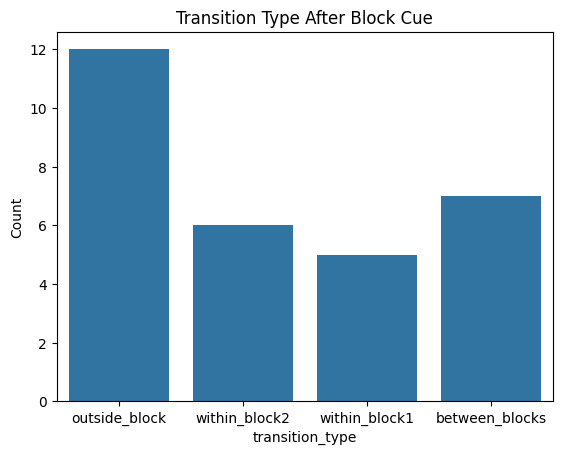

In [52]:
# count up each type of transition
first_transitions['transition_type'].value_counts(normalize=True)

sns.countplot(data=first_transitions, x='transition_type')
plt.title("Transition Type After Block Cue")
plt.ylabel("Count")